### implementing the word2vec

In [1]:
import re
import numpy as np
import torch.nn as nn 
import torch

In [2]:
# reading the file
# txt = """We are about to study the idea of a computational process.
# Computational processes are abstract beings that inhabit computers.
# As they evolve, processes manipulate other abstract things called data.
# The evolution of a process is directed by a pattern of rules
# called a program. People create programs to direct processes. In effect,
# we conjure the spirits of the computer with our spells."""

In [3]:
txt = """
घृणा से घृणा उत्पन्न होती है। प्रेम से प्रेम। ज्ञान भी बड़े भाई को चाहता था। कभी-कभी उसका पक्ष ले कर अपनी माँ से वाद-विवाद कर कहता भैया की अचकन फट गयी है आप नयी अचकन क्यों नहीं बनवा देतीं माँ उत्तर देती-उसके लिए वही अचकन अच्छी है। अभी क्या कभी तो वह नंगा फिरेगा। ज्ञानप्रकाश बहुत चाहता था कि अपने जेब-खर्च से बचा कर कुछ अपने भाई को दे पर सत्यप्रकाश कभी इसे स्वीकार न करता था। वास्तव में जितनी देर वह छोटे भाई के साथ रहता उतनी देर उसे एक शांतिमय आनन्द का अनुभव होता। थोड़ी देर के लिए वह सद्भावों के साम्राज्य में विचरने लगता। उसके मुख से कोई भद्दी और अप्रिय बात न निकलती। एक क्षण के लिए उसकी सोयी हुई आत्मा जाग उठती।
"""

In [4]:
# removing the special chars
# txt = re.sub('[^A-Za-z0-9]+', ' ', txt)

txt = re.sub(r'(?:^| )\w(?:$| )', ' ', txt).strip()
text = txt.lower()

In [5]:
# only keeping the unique words
words = text.split()
vocab = set(words)

In [6]:
# print(words)
print(len(words))

126


In [7]:
vocab_size = len(vocab)
embed_dim = 10 #depends on the dataset but since our dataset is small
context_size = 2 #how many before and after words to use.

In [8]:
# creating the token ids
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}

In [9]:
# data bags
# data = [(context), target]

data = []
for i in range(2, len(words)-2):
    context = [words[i-2], words[i-1], words[i+1], words[i+2]]
    target = words[i]
    data.append((context, target))

In [10]:
data[:5]

[(['घृणा', 'से', 'उत्पन्न', 'होती'], 'घृणा'),
 (['से', 'घृणा', 'होती', 'है।'], 'उत्पन्न'),
 (['घृणा', 'उत्पन्न', 'है।', 'प्रेम'], 'होती'),
 (['उत्पन्न', 'होती', 'प्रेम', 'से'], 'है।'),
 (['होती', 'है।', 'से', 'प्रेम।'], 'प्रेम')]

In [11]:
context, target = data[0]
target

'घृणा'

In [12]:
# create the continous BOW
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOW, self).__init__()

        # 1 x embed_dim
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear1 = nn.Linear(embed_dim, 128)
        self.activation = nn.ReLU()

        # 1 x vocab size
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1, -1)
        out = self.linear1(embeds)
        out = self.activation(out)
        out = self.linear2(out)
        return out

In [13]:
model = CBOW(vocab_size=vocab_size, embed_dim=embed_dim)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [15]:
model.train()
total_loss = []

for epoch in range(80):
    epoch_loss = 0
    for context, target in data:
        context_ids = torch.tensor([word_to_idx[w] for w in context])
        target_id = torch.tensor([word_to_idx[target]])
        
        # Forward pass
        preds = model(context_ids)
        
        # Calculate loss
        loss = loss_fn(preds, target_id)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {epoch_loss/len(data)}')

    total_loss.append(epoch_loss)
    

Epoch: 0 | Loss: 4.751509711390636
Epoch: 10 | Loss: 1.3466401852545191
Epoch: 20 | Loss: 0.3077082114263636
Epoch: 30 | Loss: 0.11717897833737194
Epoch: 40 | Loss: 0.06486773756561709
Epoch: 50 | Loss: 0.04324681717200113
Epoch: 60 | Loss: 0.031918366828963894
Epoch: 70 | Loss: 0.02504454970695689


In [16]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

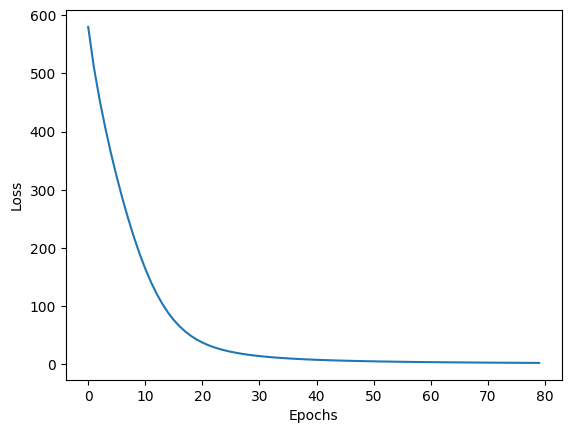

In [17]:
epo = range(80)
plt.plot(epo, total_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [18]:
def predict_word(context_words):
    context_ids = torch.tensor([word_to_idx[w] for w in context_words])
    with torch.no_grad():
        preds = model(context_ids)
        _, predicted_idx = torch.max(preds, 1)
        predicted_word = idx_to_word[predicted_idx.item()]
    return predicted_word

In [20]:
# Example usage
context = ['से', 'घृणा', 'होती', 'है।']
predicted = predict_word(context)
print(f"Context: {context}")
print(f"Predicted word: {predicted}")

Context: ['से', 'घृणा', 'होती', 'है।']
Predicted word: उत्पन्न
